In [32]:
import sys
sys.path.insert(0,'/home/emmanuel/Drives/erc/code/gp_autograd')
sys.path.insert(0,'/Users/eman/Documents/code_projects/gp_autograd')

# Import Kernellib 
sys.path.insert(0, '/Users/eman/Documents/code_projects/kernellib')
import numpy as np
from gp_autograd.gaussianprocess import GaussianProcess
from gp_autograd.data import sample_data
from sklearn.gaussian_process.kernels import (RBF, WhiteKernel, ConstantKernel as C)
from kernellib.derivatives import ard_derivative

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
!pwd

/Users/eman/Documents/code_projects/gp_autograd/notebooks


### Sample Data

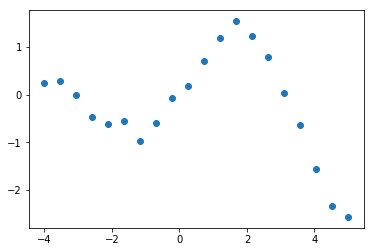

In [34]:
xtrain, xtest, ytrain, ytest = sample_data()

# Plot
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain)

plt.show()


## Fit GP Model

In [35]:
%%time 

# Initialize GP Model
gp_model = GaussianProcess(kernel='rbf', normalize_y=True, n_restarts=20)

gp_model.fit(xtrain, ytrain);

CPU times: user 1.01 s, sys: 108 ms, total: 1.12 s
Wall time: 1.31 s


### Predictions and Variance

#### Autograd GP

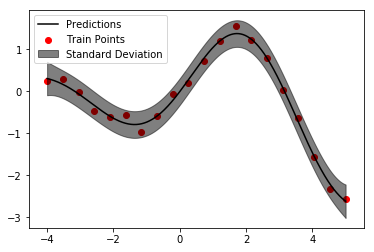

In [36]:
# Get predictions
y_pred, y_std = gp_model.predict(xtest, return_std=True)

# Plot results
fig, ax = plt.subplots()

upper_limit = y_pred.squeeze() + 2*y_std.squeeze()
lower_limit = y_pred.squeeze() - 2*y_std.squeeze()




ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.scatter(xtrain, ytrain, color='red', label='Train Points')
ax.fill_between(xtest.squeeze(), upper_limit, lower_limit,
                color='k', alpha=0.5, label='Standard Deviation')

ax.legend()
plt.show()


### 1st Derivative


#### Numerical

In [37]:
d1_numerical = gp_model.mu_grad(xtest)          # 1st Derivative
d2_numerical = gp_model.mu_grad(xtest, nder=2)          # 1st Derivative

#### Analytical

In [38]:
weights = gp_model.weights
signal_variance = gp_model.signal_variance
length_scale = gp_model.length_scale

d1_analytical = ard_derivative(xtrain, xtest, weights, length_scale, signal_variance)

np.testing.assert_array_almost_equal(d1_analytical, d1_numerical)

#### Plot

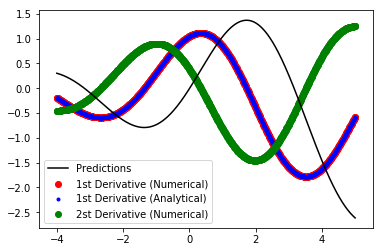

In [39]:
# Plot results
fig, ax = plt.subplots()

ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.scatter(xtest, d1_numerical, color='red', marker='o', label='1st Derivative (Numerical)')
ax.scatter(xtest, d1_analytical, color='blue', marker='.', label='1st Derivative (Analytical)')
ax.scatter(xtest, d2_numerical, color='green', marker='o', label='2st Derivative (Numerical)')


ax.legend()
plt.show()

## Sensitivity

In [40]:
p_sens = gp_model.point_sensitivity(xtest, sample='point', method='squared')
sens = gp_model.sensitivity(xtest, method='squared')
print('Sensitivity:', sens)

Sensitivity: 0.8941170029151917


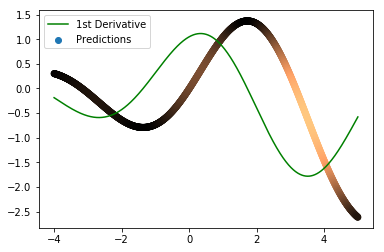

In [41]:
# Plot results
fig, ax = plt.subplots()

ax.scatter(xtest, y_pred, c=p_sens[:, np.newaxis], cmap='copper', label='Predictions')
ax.plot(xtest, d1_numerical, color='green', label='1st Derivative')
# ax.plot(xtest, p_sens, color='blue', label='Sensitivity')

ax.legend()
plt.show()

## MultiDimensional Example

In [42]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [13]:
X, y = load_boston().data, load_boston().target

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=123)
print(xtrain.shape, xtest.shape)

(404, 13) (102, 13)


/Users/eman/anaconda3/envs/gpytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### RBF Kernel

In [23]:
%%time
# Initialize GP Model
gp_model = GaussianProcess(kernel='rbf', normalize_y=True)

gp_model.fit(xtrain, ytrain);

y_pred = gp_model.predict(xtest)

CPU times: user 19 s, sys: 1.41 s, total: 20.5 s
Wall time: 10.9 s


In [24]:
mse = mean_squared_error(y_pred, ytest)
mae = mean_absolute_error(y_pred, ytest)
r2 = r2_score(y_pred, ytest)
print(mse, mae, r2)

15.908410069442672 2.606954473210345 0.7760486609925497


#### Sensitvity

In [25]:
d_sens = gp_model.point_sensitivity(xtest, sample='dim', method='squared')
sens = gp_model.sensitivity(xtest, method='squared')
print('Sensitivity:', sens)

Sensitivity: 7.038445583505699


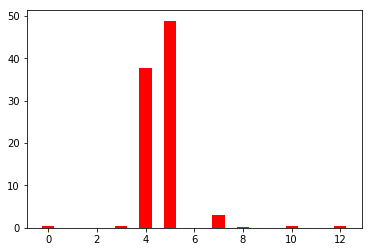

In [26]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, d_sens, width, color='r', label='ARD')

plt.show()

### ARD Kernel

In [27]:
%%time
# Initialize GP Model
gp_model = GaussianProcess(kernel='ard', normalize_y=True)

gp_model.fit(xtrain, ytrain);

y_pred = gp_model.predict(xtest)

CPU times: user 36.4 s, sys: 2.27 s, total: 38.7 s
Wall time: 19.2 s


In [28]:
mse = mean_squared_error(y_pred, ytest)
mae = mean_absolute_error(y_pred, ytest)
r2 = r2_score(y_pred, ytest)
print(mse, mae, r2)

10.74687049039384 2.133403227386172 0.8422473712782304


#### Automatic Relevance Determination 

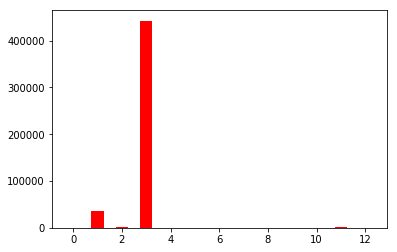

In [29]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, gp_model.length_scale, width, color='r', label='ARD')

plt.show()

#### Sensitivity

In [30]:
d_sens = gp_model.point_sensitivity(xtest, sample='dim', method='squared')
sens = gp_model.sensitivity(xtest, method='squared')
print('Sensitivity:', sens)

Sensitivity: 232.1369612575506


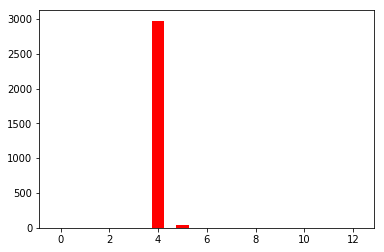

In [31]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, d_sens, width, color='r', label='ARD')

plt.show()